## Basics of TS:

Collation of different basic concepts of the different traditional time-series models and some basic intuition behind them

## Objective:
This kernel was made to serve as repository of various time-series concepts for beginners and I hope it would be useful as a refresher to some of the experts too :)

## Table of contents:
* Competition and data overview
* Imports ( data and packages )
* Basic exploration/EDA
* Single time-series 
    * Stationarity
    * Seasonality , Trend and Remainder
    * AR , MA , ARMA , ARIMA
    * Selecting P and Q using AIC
    * ETS
    * Prophet 
    * UCM
* Hierarchical time-series
    * Bottom's up
    * AHP
    * PHA 
    * FP 
    
    
## Competition and data overview:

In this playground competition, we are provided with the challenge of predicting total sales for every product and store in the next month for Russian Software company-[1c company](http://1c.ru/eng/title.htm). 

**What does the IC company do?:**

1C: Enterprise 8 system of programs is intended for automation of everyday enterprise activities: various business tasks of economic and management activity, such as management accounting, business accounting, HR management, CRM, SRM, MRP, MRP, etc.

**Data**:
We are provided with daily sales data for each store-item combination, but our task is to predict sales at a monthly level.

## Imports:


In [1]:
# always start with checking out the files!
!ls ../input/*

../input/item_categories.csv  ../input/sample_submission.csv.gz
../input/items.csv	      ../input/shops.csv
../input/sales_train.csv.gz   ../input/test.csv.gz


In [2]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")



In [5]:
# Import all of them 
sales=pd.read_csv("../input/sales_train_v2.csv")

# settings
import warnings
warnings.filterwarnings("ignore")

item_cat=pd.read_csv("../input/item_categories.csv")
item=pd.read_csv("../input/items.csv")
sub=pd.read_csv("../input/sample_submission.csv")
shops=pd.read_csv("../input/shops.csv")
test=pd.read_csv("../input/test.csv")

In [6]:
#formatting the date column correctly
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
# check
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


Definition of the variable monthly_sales, which is not necessarily useful for the run of fit and predictions but seems to be useful to have a different view of the file data by using the groupby option in a complicated way. It is maybe useful for the stat analysis, but I have my doubts since the main object for the analysis is mostly given by ts kind of variable with columns date_block and item_count

In [7]:
# Aggregate to monthly level the required metrics

monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

## Lets break down the line of code here:
# aggregate by date-block(month),shop_id and item_id
# select the columns date,item_price and item_cnt(sales)
# Provide a dictionary which says what aggregation to perform on which column
# min and max on the date
# average of the item_price
# sum of the sales

# take a peak
monthly_sales.head(20)

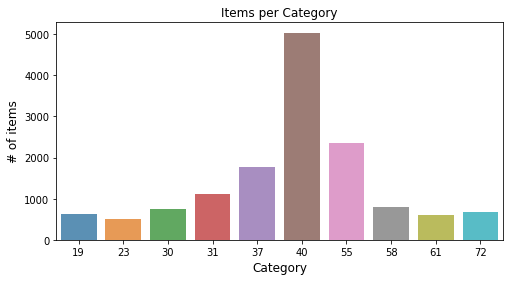

In [8]:
# number of items per cat 
#notice that the analisis tupla is simply x

x=item.groupby(['item_category_id']).count()

x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
x
# #plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

Of course, there is a lot more that we can explore in this dataset, but let's dive into the time-series part.

# Single series:

The objective requires us to predict sales for the next month at a store-item combination.

Sales over time of each store-item is a time-series in itself. Before we dive into all the combinations, first let's understand how to forecast for a single series.

I've chosen to predict for the total sales per month for the entire company.

First let's compute the total sales per month and plot that data.


In [9]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [10]:
monthly_sales.head()

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0

Now, we declare a new variable to define the data to analyze in terms of time series predictions
basically, the item_cnt_day added in differents directions, such as date_block_num or date_block_num x shop_id x item_id, etc.

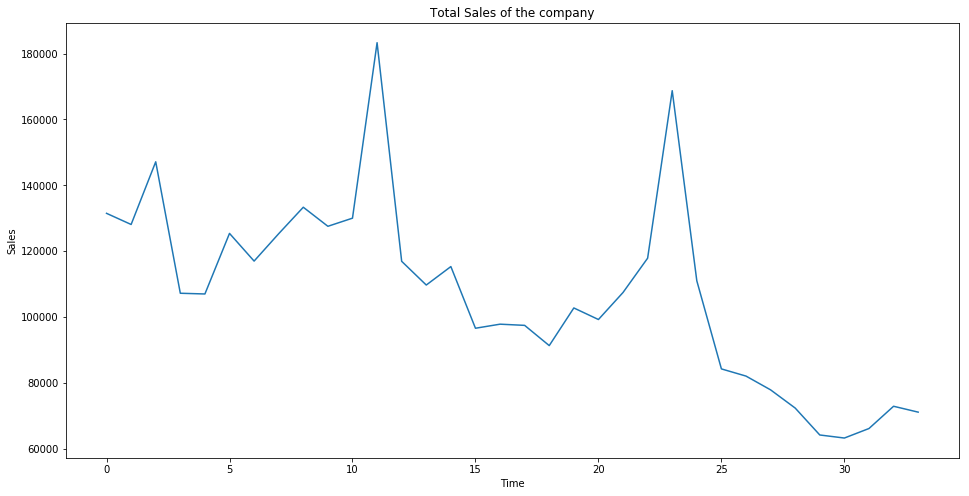

In [11]:
#declaration of time-series kind of variable ts with groupby, but the structure is simple

ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()


ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

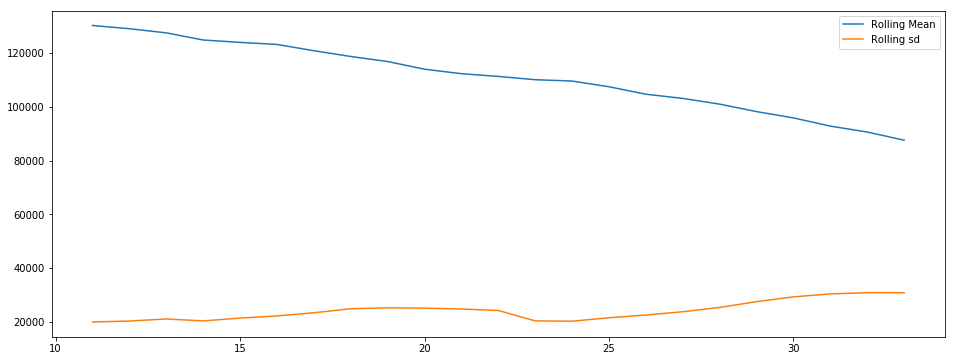

In [12]:
#with ts.rolling we are computing the mean and std of sales grouped in windows of size 12 in units of time (block times, indeed)

plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

**Quick observations:**
There is an obvious "seasonality" (Eg: peak sales around a time of year) and a decreasing "Trend".

Let's check that with a quick decomposition into Trend, seasonality and residuals.


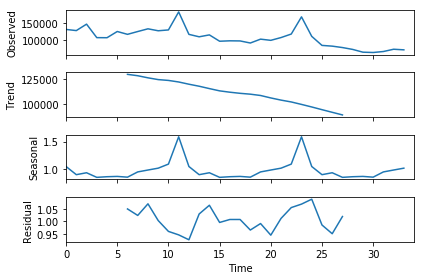

In [13]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

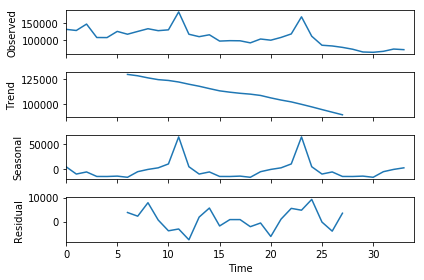

In [14]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

In [ ]:
# R version ported into python  

# alas ! rpy2 does not exist in Kaggle kernals :( 
# from rpy2.robjects import r
# def decompose(series, frequency, s_window, **kwargs):
#     df = pd.DataFrame()
#     df['date'] = series.index
#     s = [x for x in series.values]
#     length = len(series)
#     s = r.ts(s, frequency=frequency)
#     decomposed = [x for x in r.stl(s, s_window, **kwargs).rx2('time.series')]
#     df['observed'] = series.values
#     df['trend'] = decomposed[length:2*length]
#     df['seasonal'] = decomposed[0:length]
#     df['residual'] = decomposed[2*length:3*length]
#     return df

we assume an additive model, then we can write

> yt=St+Tt+Et 

where yt is the data at period t, St is the seasonal component at period t, Tt is the trend-cycle component at period tt and Et is the remainder (or irregular or error) component at period t
Similarly for Multiplicative model,

> yt=St  x Tt x Et 

## Stationarity:

![q](https://static1.squarespace.com/static/53ac905ee4b003339a856a1d/t/5818f84aebbd1ac01c275bac/1478031479192/?format=750w)

Stationarity refers to time-invariance of a series. (ie) Two points in a time series are related to each other by only how far apart they are, and not by the direction(forward/backward)

When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary.


There are multiple tests that can be used to check stationarity.
* ADF( Augmented Dicky Fuller Test) 
* KPSS 
* PP (Phillips-Perron test)

Let's just perform the ADF which is the most commonly used one.

Note: [Step by step guide to perform dicky fuller test in Excel](http://www.real-statistics.com/time-series-analysis/stochastic-processes/dickey-fuller-test/)

[Another Useful guide](http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016#AR) 

[good reference](https://github.com/ultimatist/ODSC17/blob/master/Time%20Series%20with%20Python%20(ODSC)%20STA.ipynb)


# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)


# to remove trend
from pandas import Series as Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob



ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)

plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

# now testing the stationarity again after de-seasonality
test_stationarity(new_ts)

### Now after the transformations, our p-value for the DF test is well within 5 %. Hence we can assume Stationarity of the series

We can easily get back the original series using the inverse transform function that we have defined above.

Now let's dive into making the forecasts!

# AR, MA and ARMA models:
TL: DR version of the models:

MA - Next value in the series is a function of the average of the previous n number of values
AR - The errors(difference in mean) of the next value is a function of the errors in the previous n number of values
ARMA - a mixture of both.

Now, How do we find out, if our time-series is an AR process or MA process?

Let's find out!

def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

# Simulate an AR(1) process with alpha = 0.6
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
limit=12    
_ = tsplot(x, lags=limit,title="AR(1)process")

## AR(1) process -- has ACF tailing out and PACF cutting off at lag=1

# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.444, .333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=12,title="AR(2) process")

## AR(2) process -- has ACF tailing out and PACF cutting off at lag=2

# Simulate an MA(1) process
n = int(1000)
# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.8])
# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
limit=12
_ = tsplot(ma1, lags=limit,title="MA(1) process")

## MA(1) process -- has ACF cut off at lag=1

# Simulate MA(2) process with betas 0.6, 0.4
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=12,title="MA(2) process")

## MA(2) process -- has ACF cut off at lag=2

# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 12

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag,title="ARMA(2,2) process")

## Now things get a little hazy. Its not very clear/straight-forward.

A nifty summary of the above plots:

ACF Shape	| Indicated Model |
-- | -- |
Exponential, decaying to zero |	Autoregressive model. Use the partial autocorrelation plot to identify the order of the autoregressive model |
Alternating positive and negative, decaying to zero	Autoregressive model. |  Use the partial autocorrelation plot to help identify the order. |
One or more spikes, rest are essentially zero | Moving average model, order identified by where plot becomes zero. |
Decay, starting after a few lags |	Mixed autoregressive and moving average (ARMA) model. | 
All zero or close to zero | Data are essentially random. |
High values at fixed intervals | Include seasonal autoregressive term. |
No decay to zero |	Series is not stationary |


## Let's use a systematic approach to finding the order of AR and MA processes.

# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma22, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


## We've correctly identified the order of the simulated process as ARMA(2,2) (this is just a test of the previous routine !!!)


### Lets use it for the sales time-series.


# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(new_ts.values, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


Simply use best_mdl.predict() to predict the next values

# Prophet: 

Recently open-sourced by Facebook research. It's a very promising tool, that is often a very handy and quick solution to the frustrating **flatline** :P

![FLATLINE](https://i.stack.imgur.com/fWzyX.jpg)

Sure, one could argue that with proper pre-processing and carefully tuning the parameters the above graph would not happen. 

But the truth is that most of us don't either have the patience or the expertise to make it happen.

Also, there is the fact that in most practical scenarios- there is often a lot of time-series that needs to be predicted.
Eg: This competition. It requires us to predict the next month sales for the **Store - item level combinations** which could be in the thousands.(ie) predict 1000s of parameters!

Another neat functionality is that it follows the typical **sklearn** syntax.

At its core, the Prophet procedure is an additive regression model with four main components:
* A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.
* A yearly seasonal component modeled using Fourier series.
* A weekly seasonal component using dummy variables.
* A user-provided list of important holidays.

**Resources for learning more about prophet:**
* https://www.youtube.com/watch?v=95-HMzxsghY
* https://facebook.github.io/prophet/docs/quick_start.html#python-api
* https://research.fb.com/prophet-forecasting-at-scale/
* https://blog.exploratory.io/is-prophet-better-than-arima-for-forecasting-time-series-fa9ae08a5851

In [32]:
from fbprophet import Prophet

# adding the dates to the Time-series as index
#normally, ts is already created before since we have to at least plot the data the we want to analyze and this is done above
#ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()

ts.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
ts=ts.reset_index()
ts.head()

#prophet reqiures a pandas df at the below config 
# ( date column named as DS and the value column as Y)


,index,item_cnt_day
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


# First application of Prophet, using the full but simple ts dataframe

In [34]:
ts.columns=['ds','y']
model = Prophet(yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(ts) #fit the model with your dataframe

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [35]:
# predict for five months in the furure and MS - month start is the frequency
future = model.make_future_dataframe(periods = 5, freq = 'MS')  
# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
34,2015-11-01,82558.893662,79680.573661,85627.916662
35,2015-12-01,127402.291109,124259.316979,130492.549028
36,2016-01-01,76816.889777,73531.964011,79765.452189
37,2016-02-01,39858.854832,36946.506390,43106.313168
38,2016-03-01,78277.647239,75297.078732,81209.103062


In [36]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,140995.681931,128810.957675,134958.603785,140995.681931,140995.681931,-9135.864846,-9135.864846,-9135.864846,-9135.864846,-9135.864846,-9135.864846,0.0,0.0,0.0,131859.817085
1,2013-02-01,139342.174225,128671.289901,134449.341993,139342.174225,139342.174225,-7874.110915,-7874.110915,-7874.110915,-7874.110915,-7874.110915,-7874.110915,0.0,0.0,0.0,131468.063310
2,2013-03-01,137848.683396,145462.741571,151365.390307,137848.683396,137848.683396,10437.756663,10437.756663,10437.756663,10437.756663,10437.756663,10437.756663,0.0,0.0,0.0,148286.440060
3,2013-04-01,136195.175710,103844.429884,110009.844863,136195.175710,136195.175710,-29159.344968,-29159.344968,-29159.344968,-29159.344968,-29159.344968,-29159.344968,0.0,0.0,0.0,107035.830742
4,2013-05-01,134595.007014,103781.082153,110185.541377,134595.007014,134595.007014,-27620.541343,-27620.541343,-27620.541343,-27620.541343,-27620.541343,-27620.541343,0.0,0.0,0.0,106974.465671


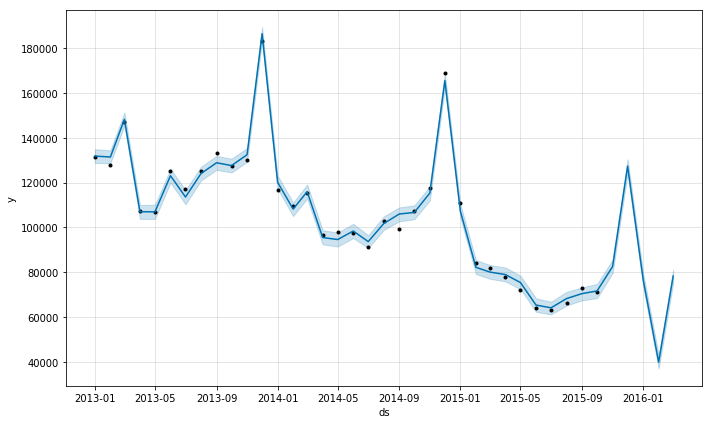

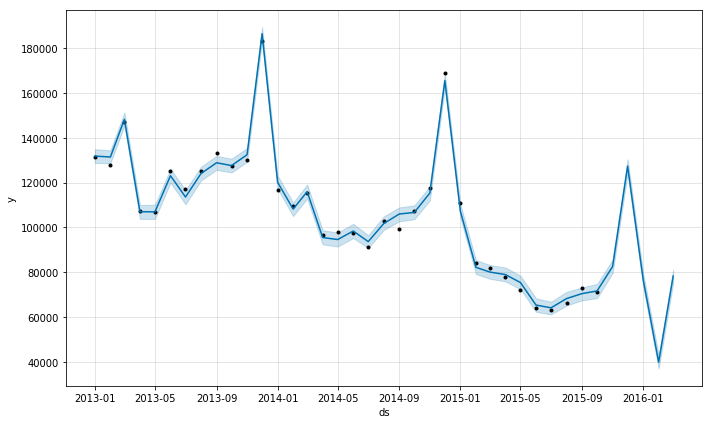

In [37]:
model.plot(forecast)

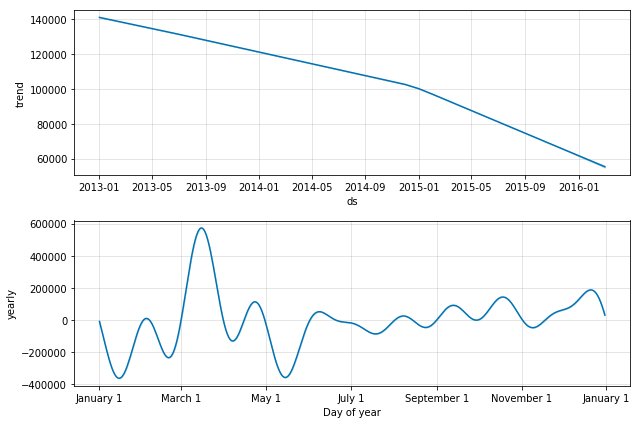

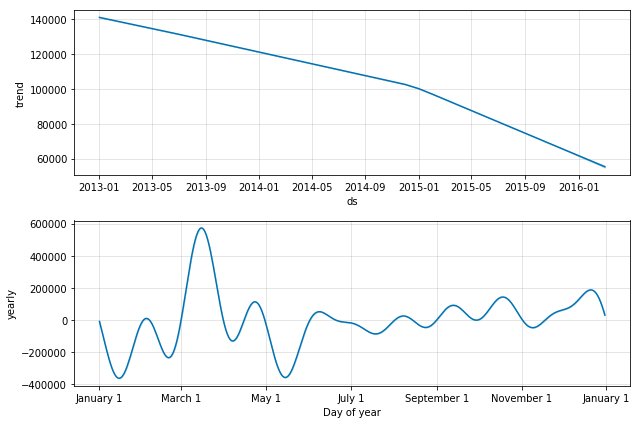

In [38]:
model.plot_components(forecast)

Awesome. The trend and seasonality from Prophet look similar to the ones that we had earlier using the traditional methods.

## UCM:

Unobserved Components Model. The intuition here is similar to that of the prophet. The model breaks down the time-series into its components, trend, seasonal, cycle and regresses them and then predicts the next point for the components and then combines them.

Unfortunately, I could not find a good package/code that can perform this model in Python :( 

R version of UCM: https://bicorner.com/2015/12/28/unobserved-component-models-in-r/

# Hierarchical time series:

The [Forecasting: principles and practice](https://www.otexts.org/fpp/9/4) , is the ultimate reference book for forecasting by Rob J Hyndman.

He lays out the fundamentals of dealing with grouped or Hierarchical forecasts. Consider the following simple scenario.

![](https://www.otexts.org/sites/default/files/resize/fpp/images/hts1-550x274.png)

Hyndman proposes the following methods to estimate the points in this hierarchy. I've tried to simplify the language to make it more intuitve.

### Bottom up approach:
* Predict all the base level series using any method, and then just aggregate it to the top.
* Advantages: Simple , No information is lost due to aggregation.
* Dis-advantages: Lower levels can be noisy

### Top down approach:
* Predict the top level first. (Eg: predict total sales first)
* Then calculate **weights** that denote the proportion of the total sales that needs to be given to the base level forecast(Eg:) the contribution of the item's sales to the total sales 
* There are different ways of arriving at the "weights". 
    * **Average Historical Proportions** - Simple average of the item's contribution to sales in the past months
    * **Proportion of historical averages** - Weight is the ratio of average value of bottom series by the average value of total series (Eg: Weight(item1)= mean(item1)/mean(total_sales))
    * **Forecasted Proportions** - Predict the proportion in the future using changes in the past proportions
* Use these weights to calcuate the base -forecasts and other levels

### Middle out:
* Use both bottom up and top down together.
* Eg: Consider our problem of predicting store-item level forecasts.
    * Take the middle level(Stores) and find forecasts for the stores
    * Use bottoms up approach to find overall sales
    * Dis-integrate store sales using proportions to find the item-level sales using a top-down approach
    
### Optimal combination approach:
* Predict for all the layers independently
* Since, all the layers are independent, they might not be consistent with hierarchy
    * Eg: Since the items are forecasted independently, the sum of the items sold in the store might not be equal to the forecasted sale of store  or as Hyndman puts it “aggregate consistent”
* Then some matrix calculations and adjustments happen to provide ad-hoc adjustments to the forecast to make them consistent with the hierarchy


### Enough with the theory. Lets start making forecasts! :P
The problem at hand here, has 22170 items and 60 stores . This indicates that there can be around a **million** individual time-series(item-store combinations) that we need to predict!

Configuring each of them would be nearly impossible. Let's use Prophet which does it for us.

Starting off with the bottoms up approach.

There are some other points to consider here: 
* Not all stores sell all items
* What happens when a new product is introduced? 
* What if a product is removed off the shelves?

# Second time that we apply prophet, 

## This time we run over node (shop_id x item_id) time series. Simply because the submission file is required in this direction of predictions, not the previous one

In [17]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [18]:
#Function that generate the input for prophet for any shop_id x item_id combination, which are read as free parameters

def sales_shop_item_prophet_input(shop_id_history, item_id_history):
   
    sales_shop_item = sales[(sales.shop_id==shop_id_history) & (sales.item_id == item_id_history)]
    monthly_sales_shop_item = sales_shop_item.groupby(["date_block_num"])["item_cnt_day"].sum()
    
    dates = pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
    nullhistory = pd.DataFrame({"ds":dates,"y":[0]*dates.shape[0]},columns=["ds","y"])
    
    if (sales_shop_item.shape[0] > 0):
        for con in range(monthly_sales_shop_item.shape[0]): 
            index_date_block = monthly_sales_shop_item.index[con]
            count_date_block = monthly_sales_shop_item.iloc[con]
    
            nullhistory.iloc[index_date_block,1] = count_date_block
    
    return nullhistory    

In [19]:
sales_shop_item_prophet_input(test.iloc[0,1], test.iloc[0,2])

,ds,y
0,2013-01-01,0.0
1,2013-02-01,0.0
2,2013-03-01,0.0
3,2013-04-01,0.0
4,2013-05-01,0.0
5,2013-06-01,0.0
6,2013-07-01,0.0
7,2013-08-01,0.0
8,2013-09-01,0.0
9,2013-10-01,0.0


In [20]:
nodeToForecast = sales_shop_item_prophet_input(test.iloc[0,1], test.iloc[0,2])


In [21]:
nodeToForecast

,ds,y
0,2013-01-01,0.0
1,2013-02-01,0.0
2,2013-03-01,0.0
3,2013-04-01,0.0
4,2013-05-01,0.0
5,2013-06-01,0.0
6,2013-07-01,0.0
7,2013-08-01,0.0
8,2013-09-01,0.0
9,2013-10-01,0.0


In [22]:
nodeToForecast.iloc[:,1].mean()

0.38235294117647056

In [23]:
range(len(test))

range(0, 214200)

In [41]:
import time
start_time=time.time()

# Bottoms up
# Calculating the base forecasts using prophet
# From HTSprophet pachage -- https://github.com/CollinRooney12/htsprophet/blob/master/htsprophet/hts.py
forecastsDict = {}
list_of_nodes =[]
list_of_predictions = []

status_file = open('status_file_prophet.txt','w+')
status_file.write("Dont be patient\n")
status_file.close()


for node in range(len(test)):
#for node in range(40):
    # take the date-column and the col to be forecasted

    test_shop_id_index = test.iloc[node,1]
    test_item_id_index = test.iloc[node,2]
  
    nodeToForecast = sales_shop_item_prophet_input(test_shop_id_index, test_item_id_index)

    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods = 1, freq = 'MS')
    forecastsDict[node] = m.predict(future)
    
    location_of_prediction_month = forecastsDict[node].shape[0] - 1
    location_of_prediction_yhat = forecastsDict[node].shape[1] - 1
      
    prediction_sales_next_month = forecastsDict[node].iloc[location_of_prediction_month,location_of_prediction_yhat]
    
    #print(node,test_shop_id_index,test_item_id_index,prediction_sales_next_month)
    
    #prediction_sales_next_month = nodeToForecast.iloc[:,1].mean()
    
    #prediction_sales_next_month = 0.5
    
    list_of_nodes.append(node)
    list_of_predictions.append(prediction_sales_next_month)
    
    if (((node % 10 == 0) and (node < 100)) or (node % 1000 == 0)):
        end_time=time.time()
        
        #status_output = "forecasting for "+ str(node) +"th node and took" + str(end_time-start_time) + "s"

        status_file = open('status_file_prophet.txt','a')
        
        status_file.write("Node "+ str(node) +" took " + str(end_time-start_time) + " s with ") 
        status_file.write("Prediction: "+ str(memory_based_prediction_for_next_month[0]) + "\n")

        status_file.close()

        #print()
        start_time=end_time

#total submission file        
        
    
    
dfsubmission = pd.DataFrame({"ID":list_of_nodes,"item_cnt_month":list_of_predictions},
                            columns=["ID","item_cnt_month"])

dfsubmission.to_csv('submission_file_prophet.csv',index=False)

forecasting for  0 th node and took 1.1742453575134277 s
0 5 5037 1.1945817998687411
forecasting for  10 th node and took 11.602017641067505 s
10 5 4806 4.169067966456238
forecasting for  20 th node and took 11.623176097869873 s
20 5 4717 1.4401475892926205
forecasting for  30 th node and took 12.09986424446106 s
30 5 5666 0.9316866008481048
forecasting for  40 th node and took 11.857994794845581 s
40 5 5840 0.17856560234141425
forecasting for  1000 th node and took 1153.8868432044983 s
1000 5 6082 0.5471088147528932
forecasting for  2000 th node and took 1183.9992916584015 s
2000 5 18255 0.0058325542696072985
forecasting for  3000 th node and took 1165.777021408081 s
3000 5 11915 -0.15464028430396792
forecasting for  4000 th node and took 1162.0242688655853 s
4000 5 14760 0.0
forecasting for  5000 th node and took 1148.1830804347992 s
5000 5 18707 0.0
forecasting for  6000 th node and took 1182.2679553031921 s
6000 4 1239 0.00912961377866528
forecasting for  7000 th node and took 1179

forecasting for  91000 th node and took 1163.618953704834 s
91000 18 9534 0.0
forecasting for  92000 th node and took 1164.9325244426727 s
92000 14 6731 0.0
forecasting for  93000 th node and took 1200.0832703113556 s
93000 14 6090 0.12945118619973062
forecasting for  94000 th node and took 1177.889792919159 s
94000 14 11711 -1.6465300388283959
forecasting for  95000 th node and took 1175.9177448749542 s
95000 14 14962 0.0
forecasting for  96000 th node and took 1165.8241600990295 s
96000 14 13327 0.0
forecasting for  97000 th node and took 1163.025004863739 s
97000 19 3733 34.757972841957425
forecasting for  98000 th node and took 1207.518203496933 s
98000 19 10211 0.491333921660421
forecasting for  99000 th node and took 1199.9733426570892 s
99000 19 21842 0.02541570930510137
forecasting for  100000 th node and took 1175.3479542732239 s
100000 19 4364 0.5145957274516173
forecasting for  101000 th node and took 1173.4832561016083 s
101000 19 20196 0.0
forecasting for  102000 th node a

KeyboardInterrupt: 

In [30]:
dfsubmission

,ID,item_cnt_month
0,0,0.382353
1,1,0.000000
2,2,0.294118
3,3,0.029412
4,4,0.000000
5,5,0.323529
6,6,0.147059
7,7,0.235294
8,8,1.852941
9,9,0.000000


In [ ]:
dfsubmission.to_csv('submission_file.csv',index=False)

# get the unique combinations of item-store from the sales data at monthly level
monthly_sales=sales.groupby(["shop_id","item_id","date_block_num"])["item_cnt_day"].sum()
# arrange it conviniently to perform the hts 
monthly_sales=monthly_sales.unstack(level=-1).fillna(0)
monthly_sales=monthly_sales.T
dates=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
monthly_sales.index=dates
monthly_sales=monthly_sales.reset_index()
monthly_sales.head()

import time
start_time=time.time()

# Bottoms up
# Calculating the base forecasts using prophet
# From HTSprophet pachage -- https://github.com/CollinRooney12/htsprophet/blob/master/htsprophet/hts.py
forecastsDict = {}
dates_column = monthly_sales.iloc[:,0]

for node in range(len(monthly_sales)):
    # take the date-column and the col to be forecasted

  
    sales_column = monthly_sales.iloc[:,node+1]
    
    nodeToForecast = pd.DataFrame({'ds': dates_column, 'y': sales_column}, columns=['ds', 'y'])
    
    #nodeToForecast = pd.concat([monthly_sales.iloc[:,0], monthly_sales.iloc[:, node+1]], axis = 1)
    #print(nodeToForecast.head())  # just to check
    #rename for prophet compatability
    #nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[0] : 'ds'})
    #nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[1] : 'y'})
    
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods = 1, freq = 'MS')
    forecastsDict[node] = m.predict(future)
    if (node== 10):
        end_time=time.time()
        print("forecasting for ",node,"th node and took",end_time-start_time,"s")
        break
    

~16s for 10 predictions. We need a million predictions. This would not work out.

# Middle out:
Let's predict for the store level

monthly_shop_sales=sales.groupby(["date_block_num","shop_id"])["item_cnt_day"].sum()
# get the shops to the columns
monthly_shop_sales=monthly_shop_sales.unstack(level=1)
monthly_shop_sales=monthly_shop_sales.fillna(0)
monthly_shop_sales.index=dates
monthly_shop_sales=monthly_shop_sales.reset_index()
monthly_shop_sales.head()

monthly_item_sales=sales.groupby(["date_block_num","item_id"])["item_cnt_day"].sum()
# get the shops to the columns
monthly_item_sales=monthly_item_sales.unstack(level=1)
monthly_item_sales=monthly_item_sales.fillna(0)
monthly_item_sales.index=dates
monthly_item_sales=monthly_item_sales.reset_index()
monthly_item_sales.head()

monthly_item_sales

Forecast of Monthly Sales per Shop

start_time=time.time()

# Calculating the base forecasts using prophet
# From HTSprophet pachage -- https://github.com/CollinRooney12/htsprophet/blob/master/htsprophet/hts.py
forecastsDict = {}
for node in range(len(monthly_shop_sales)):
    
    dates_column = monthly_shop_sales.iloc[:,0]
    sales_column = monthly_shop_sales.iloc[:,node+1]
    
    nodeToForecast = pd.DataFrame({'ds': dates_column, 'y': sales_column}, columns=['ds', 'y'])
    
    #take the date-column and the col to be forecasted
    #nodeToForecast = pd.concat([monthly_shop_sales.iloc[:,0], monthly_shop_sales.iloc[:, node+1]], axis = 1)
    #print(nodeToForecast.head())  # just to check
    # rename for prophet compatability
    #nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[0] : 'ds'})
    #nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[1] : 'y'})
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods = 1, freq = 'MS')
    forecastsDict[node] = m.predict(future)
    


Forecast of Monthly Sales per Item

start_time=time.time()

# Calculating the base forecasts using prophet
# From HTSprophet pachage -- https://github.com/CollinRooney12/htsprophet/blob/master/htsprophet/hts.py
forecastsDict = {}
for node in range(len(monthly_item_sales)):
    
    dates_column = monthly_item_sales.iloc[:,0]
    sales_column = monthly_item_sales.iloc[:,node+1]
    
    nodeToForecast = pd.DataFrame({'ds': dates_column, 'y': sales_column}, columns=['ds', 'y'])
    
    #take the date-column and the col to be forecasted
    #nodeToForecast = pd.concat([monthly_shop_sales.iloc[:,0], monthly_shop_sales.iloc[:, node+1]], axis = 1)
    #print(nodeToForecast.head())  # just to check
    # rename for prophet compatability
    #nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[0] : 'ds'})
    #nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[1] : 'y'})
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods = 1, freq = 'MS')
    forecastsDict[node] = m.predict(future)
    

forecastsDict[32]

test

#predictions = np.zeros([len(forecastsDict[0].yhat),1]) 
nCols = len(list(forecastsDict.keys()))+1
for key in range(0, nCols-1):
    f1 = np.array(forecastsDict[key].yhat)
    f2 = f1[:, np.newaxis]
    if key==0:
        predictions=f2.copy()
       # print(predictions.shape)
    else:
       predictions = np.concatenate((predictions, f2), axis = 1)

predictions

predictions_unknown=predictions[-1]
predictions_unknown

## Under construction...........

### Unconventional techniques: converting TS into a regression problem

### Dealing with Hierarchy
### Codes for top down, optimal ,etc



## Foot-notes:

I'm not a stats major, so please do let me know in the comments if you feel that I've left out any important technique or if there was any mistake in the content.

I plan to add another kernel about Time-series here which would be about adapting the open-source solutions from the recent time-series competitions ( Favorita, Recruit,etc. ) to this playground dataset.

Do leave a comment/upvote :) 